Удалось получить confusion-матрицу из единиц на диагонали для прилагательных одного склонения. (НОВЫЙ и ХОРОШИЙ)

Теперь хотим собрать одну сеть для предсказания окончания всех склонений.

imports

In [1]:
import ast
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from tg.grammar_ru.common import Loc
from tg.grammar_ru.corpus import CorpusReader, CorpusBuilder, BucketCorpusBalancer
from tg.grammar_ru.corpus.corpus_reader import read_data
import os
from pathlib import Path
from dotenv import load_dotenv
load_dotenv(Loc.root_path / 'environment.env')
from tg.grammar_ru.components.yandex_storage.s3_yandex_helpers import S3YandexHandler
from tg.grammar_ru.components.yandex_delivery.training_logs import S3TrainingLogsLoader, TrainingLogsViewer

from yo_fluq_ds import Queryable, Query, fluq
import plotly.express as px
from tg.grammar_ru.common import Separator

from typing import List, Union
import numpy as np
import torch
import math
import pandas as pd
from sklearn.metrics import confusion_matrix
from tg.common import DataBundle
from tg.common.ml.batched_training import IndexedDataBundle
from tg.grammar_ru.components.plain_context_builder import PlainContextBuilder

pd.set_option('display.max_rows', 500)
from analysis_tools import get_training_results, plot_metrics, plot_cm

In [2]:
from tg.common import DataBundle
from tg.common.ml.batched_training import IndexedDataBundle
from tg.grammar_ru.components.plain_context_builder import PlainContextBuilder
bundle_0_declination_path = Loc.data_cache_path/'bundles/agreement/mid50_0_declination'
bundle_all_declination_path = Loc.data_cache_path/'bundles/agreement/mid50_all_decl'

endings & calculate masks

In [44]:
NEW = {'ая', 'ого', 'ое', 'ой', 'ом', 'ому',
       'ую', 'ые', 'ый', 'ым', 'ыми', 'ых'}
# NOTE выкинули 'ою'

GOOD = {'ая', 'его', 'ее', 'ей', 'ем', 'ему',
        'ие', 'ий', 'им', 'ими', 'их', 'ую', 'яя', 'юю',
        'ого','ое', 'ой', 'ому', 'ом'} # легкий

BIG = {'ая', 'ие', 'им', 'ими', 'их', 'ого',
       'ое', 'ой', 'ом', 'ому', 'ую',
       'ые', 'ым', 'ыми', 'ых'} # золотой
# NOTE выкинули 'ою'

NEW_list = sorted(list(NEW))
GOOD_list = sorted(list(GOOD))
BIG_list = sorted(list(BIG))
# окончания с повторами. это фича.
ALL_ENDS_list = NEW_list + GOOD_list + BIG_list
POSSIBLE_ENDINGS = set(ALL_ENDS_list)
endings_nums = {e: i for i, e in enumerate(ALL_ENDS_list)}

NEW_num_by_end = {e: i for i, e in enumerate(NEW_list)}
GOOD_num_by_end = {e: i+len(NEW_num_by_end) for i, e in enumerate(GOOD_list)}
BIG_num_by_end = {e: i+len(NEW_num_by_end)+len(GOOD_num_by_end)
                  for i, e in enumerate(BIG_list)}

nums_by_decl_and_end = (
    {('new', e): n for e, n in NEW_num_by_end.items()} |
    {('good', e): n for e, n in GOOD_num_by_end.items()} |
    {('big', e): n for e, n in BIG_num_by_end.items()}
)
end_num_df = pd.DataFrame(list((0, e, n) for e, n in NEW_num_by_end.items()) +
                          list((1, e, n) for e, n in GOOD_num_by_end.items()) +
                          list((2, e, n) for e, n in BIG_num_by_end.items()),
                          columns=['declension_type', 'ending', 'n']
                          )
mask_NEW = (end_num_df.declension_type==0).astype(int).values
mask_GOOD = (end_num_df.declension_type==1).astype(int).values
mask_BIG = (end_num_df.declension_type==2).astype(int).values
end_by_num = {n: e for (dt, e), n in nums_by_decl_and_end.items()}


In [42]:
# nums_by_decl_and_end

In [45]:
end_by_num

{0: 'ая',
 1: 'ого',
 2: 'ое',
 3: 'ой',
 4: 'ом',
 5: 'ому',
 6: 'ую',
 7: 'ые',
 8: 'ый',
 9: 'ым',
 10: 'ыми',
 11: 'ых',
 12: 'ая',
 13: 'его',
 14: 'ее',
 15: 'ей',
 16: 'ем',
 17: 'ему',
 18: 'ие',
 19: 'ий',
 20: 'им',
 21: 'ими',
 22: 'их',
 23: 'ого',
 24: 'ое',
 25: 'ой',
 26: 'ом',
 27: 'ому',
 28: 'ую',
 29: 'юю',
 30: 'яя',
 31: 'ая',
 32: 'ие',
 33: 'им',
 34: 'ими',
 35: 'их',
 36: 'ого',
 37: 'ое',
 38: 'ой',
 39: 'ом',
 40: 'ому',
 41: 'ую',
 42: 'ые',
 43: 'ым',
 44: 'ыми',
 45: 'ых'}

In [15]:
# decl_end_by_num

In [4]:
masks = pd.DataFrame(np.stack([mask_NEW,mask_GOOD, mask_BIG]), columns=[
    f'mask{i}' for i in range(len(mask_NEW))
])
masks.index.name = 'declension_type'
masks

,mask0,mask1,mask2,mask3,mask4,mask5,mask6,mask7,mask8,mask9,...,mask36,mask37,mask38,mask39,mask40,mask41,mask42,mask43,mask44,mask45
declension_type,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


In [5]:
project_name = 'agreementproject'
# dataset_name = 'agreement_adj_mid50_all_decl_masked'
bucket = 'agreementadjbucket'

## Add masks to bundle

In [6]:
from tg.projects.agreement.bundles_tools import set_mask, upload_bundle


tiny

In [9]:
tiny_all_decl_path = Loc.data_cache_path/f'bundles/agreement/tiny_all_decl'
tiny_all_decl_masked_path = Loc.data_cache_path / \
    f'bundles/agreement/tiny_all_decl_masked'
db_tiny = DataBundle.load(tiny_all_decl_path)
set_mask(tiny_all_decl_path, tiny_all_decl_masked_path, masks)
upload_bundle(tiny_all_decl_masked_path,
              'agreement_adj_tiny_all_decl_masked', bucket, project_name)


mid

In [25]:
mid_all_decl_path = Loc.data_cache_path/f'bundles/agreement/mid50_all_decl'
mid_all_decl_masked_path = Loc.data_cache_path / \
    f'bundles/agreement/mid50_all_decl_masked'
# db = DataBundle.load(mid_all_decl_path)
# set_mask(mid_all_decl_path, mid_all_decl_masked_path, masks)
# upload_bundle(mid_all_decl_masked_path,
#               'agreement_adj_mid50_all_decl_masked', bucket, project_name)


In [37]:
td = db.index[db.index.split.isin(['train','display'])]

In [11]:
# td.head(15)

In [7]:
import eule
diagram = eule.euler({
    'new':list(NEW),
    'good':list(GOOD),
    'big':list(BIG),
                      })
print(diagram)

{'good': ['юю', 'ем', 'его', 'ему', 'ей', 'ий', 'ее', 'яя'], 'big,good': ['ие', 'их', 'им', 'ими'], 'big,good,new': ['ая', 'ой', 'ую', 'ого', 'ому', 'ое', 'ом'], 'big,new': ['ых', 'ым', 'ые', 'ыми'], 'new': ['ый']}


In [8]:
from tg.grammar_ru.features import PyMorphyFeaturizer, SlovnetFeaturizer, SyntaxTreeFeaturizer, SyntaxStatsFeaturizer
from tg.grammar_ru.common import Loc
from yo_fluq_ds import *

from tg.grammar_ru.corpus import CorpusBuilder
from tg.projects.agreement.bundle import AdjAgreementTrainIndexBuilder

In [9]:
BALANCED_PATH = Loc.corpus_path/"prepare/balanced/books&pub_tiny_balanced.zip"
reader = CorpusReader(BALANCED_PATH)


In [10]:
# df =AdjAgreementTrainIndexBuilder().select(_,reader.get_frames().first(),_)[0]

In [53]:
# job_name = 'datasphere/agreementproject/job_info/job_agreementproject_16:10:07.829611.txt'
# metrics, result_df, y_true, y_pred, tasks = get_training_results(bucket,job_name, project_name)


# plot_metrics(metrics, tasks[0])
# sorted_nums = sorted(list(y_true.unique()))
# cm = pd.DataFrame(
#     confusion_matrix(y_true, y_pred,
#                         # normalize='true'
#                      ).round(2),
#     columns=[f'pred {decl_end_by_num[n]}' for n in sorted_nums],
#     index=[f'actual {decl_end_by_num[n]}' for n in sorted_nums]
# )
# plot_cm(cm)
# cm = pd.DataFrame(
#     confusion_matrix(y_true, y_pred,
#                         normalize='true'
#                      ).round(2),
#     columns=[f'pred {ending_by_num[n]}({n})' for n in sorted_nums],
#     index=[f'actual {ending_by_num[n]}({n})' for n in sorted_nums]
# )
# plot_cm(cm)


10 epochs

output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


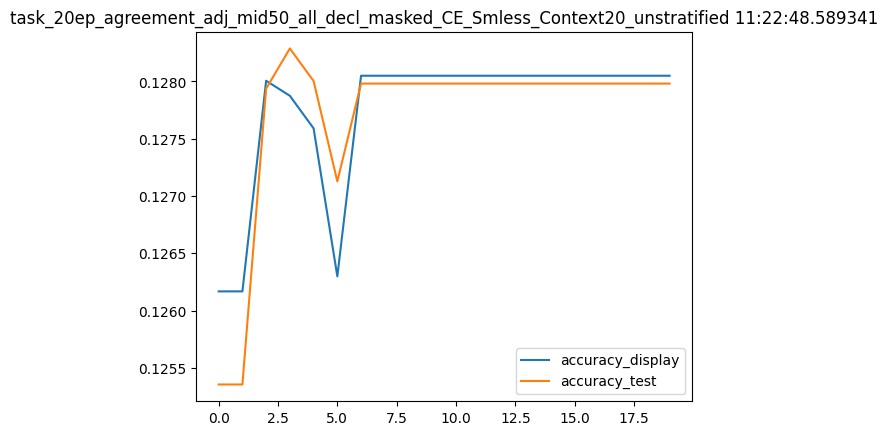

In [48]:
# job_name = 'datasphere/agreementproject/job_info/job_agreementproject_11:17:37.547687.txt'
job_name = 'datasphere/agreementproject/job_info/job_agreementproject_11:22:48.589289.txt'
metrics, result_df, y_true, y_pred, tasks = get_training_results(bucket,job_name, project_name)


plot_metrics(metrics, tasks[0])
sorted_nums = sorted(list(y_true.unique()))
cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred,
                        # normalize='true'
                     ).round(2),
    columns=[f'pred {n} {end_by_num[n]}' for n in sorted_nums],
    index=[f'actual {n} {end_by_num[n]}' for n in sorted_nums]
)
plot_cm(cm)
cm = pd.DataFrame(
    confusion_matrix(y_true, y_pred,
                        normalize='true'
                     ).round(2),
    columns=[f'pred {n} {end_by_num[n]}' for n in sorted_nums],
    index=[f'actual {n} {end_by_num[n]}' for n in sorted_nums]
)
plot_cm(cm)


In [49]:
end_num_df.groupby('declension_type').n.count()

declension_type
0    12
1    19
2    15
Name: n, dtype: int64

In [50]:
result_df

,word_id,sentence_id,declension_type,label,split,mask0,mask1,mask2,mask3,mask4,...,true_label_27,predicted_label_27,true_label_29,predicted_label_29,true_label_30,predicted_label_30,stage,pred_label,true_label,pred_score
sample_id,,,,,,,,,,,,,,,,,,,,,
3,85,11,0,8,test,1,1,1,1,1,...,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,test,8,8,1.0
6,99,11,0,3,test,1,1,1,1,1,...,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,test,8,3,1.0
8,121,12,0,3,test,1,1,1,1,1,...,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,test,8,3,1.0
10,136,12,0,2,test,1,1,1,1,1,...,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,test,8,2,1.0
13,160,13,0,7,test,1,1,1,1,1,...,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,test,8,7,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152349,2499701,2452321,1,20,display,0,0,0,0,0,...,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,display,18,20,1.0
152353,2499779,2452324,0,1,display,1,1,1,1,1,...,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,display,8,1,1.0
152356,2499802,2452325,0,2,display,1,1,1,1,1,...,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,display,8,2,1.0


In [51]:
db = DataBundle.load(mid_all_decl_masked_path)

In [52]:
import plotly.express as px
fig = px.histogram(db.index.label, histnorm=None)
fig.show()